In [1]:
import os
import sys

import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Préparation des données

Import depuis les fichiers, et jointure sur EQU_ID.

In [2]:
ot_odr_filename = os.path.join(".", "OT_ODR.csv.bz2")
ot_odr_df = pd.read_csv(ot_odr_filename, compression="bz2", sep=";")

ot_odr_df["SYSTEM_N2"] = ot_odr_df["SYSTEM_N2"].replace("-", "NONE")
ot_odr_df["SYSTEM_N3"] = ot_odr_df["SYSTEM_N3"].replace("-", "NONE")

equipements_filename = os.path.join(".", 'EQUIPEMENTS.csv')
equipements_df = pd.read_csv(equipements_filename, sep=";")

merged_df = pd.merge(ot_odr_df, equipements_df, on='EQU_ID', how='inner')

On transforme les objets (chaine de caractères) en catégories

In [3]:
var_cat = [
    'ODR_LIBELLE',
    'TYPE_TRAVAIL',
    'SYSTEM_N1',
    'SYSTEM_N2',
    'SYSTEM_N3', 
    'SIG_ORGANE',
    'SIG_CONTEXTE',
    'SIG_OBS',
    'LIGNE',
    'MODELE',
    'CONSTRUCTEUR',
    'MOTEUR',
]
for var in var_cat:
    merged_df[var] = merged_df[var].astype('category')

Séparation des données en deux jeux, un de test et un d'entrainement avec une proportion 20% / 80% du dataset.

In [4]:
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

## Création et test des modèles

Définition de fonctions et de variables utiles

In [5]:
input_to_model  = {}
output_to_model = {}
var_to_model    = {}
model           = {}

def predict(bn, data, var_target, show_progress=False):
    """
    This function is used to predict the posterior probability of a target variable from observations
    using a bayesian network model.

    Inputs:
    - =bn=: the predictive model given as a =pyAgrum.BayesNet= object
    - =data=: the data containing the observations used to predict the target variable
    as a =pandas.DataFrame= object
    - =var_target=: the name of the target variable as a =str= object

    Returns:
    - a =DataFrame= containing the posterior probability distribution of the target
    variable given each observation in =data=.
    """
    # Initialize the inference engine
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i) for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    for i in range(nb_data):
        # Set the evidence
        inf_bn.setEvidence(data_records[i])
        # Run inference
        inf_bn.makeInference()
        # Compute posterior probability of target variable
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        # Erase evidence
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

    post_prob_df = pd.DataFrame(post_prob,
                                index=data.index,
                                columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

def initialyse_model(name, df, var_to_model) :
    """ TODO """
    
    var_bn = {}
    for var in var_to_model:
        nb_values = len(df[var].cat.categories)
        var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

    for var in var_bn:
        for i, modalite in enumerate(df[var].cat.categories):
            var_bn[var].changeLabel(i, modalite)

    bn = gum.BayesNet(name)

    for var in var_bn.values():
        bn.add(var)
    
    return bn

def get_accuracy(trues, pred) :
    test_series = trues.reindex(pred.index)
    return (test_series == pred).mean()

### Premier model

In [6]:
MID = 1

input_to_model[MID] = ['SIG_ORGANE', 'SIG_OBS']
output_to_model[MID] = 'SYSTEM_N2'
var_to_model[MID] = input_to_model[MID] + ([output_to_model[MID]])

model[MID] = initialyse_model('model_3', train_df, var_to_model[MID])
model[MID].addArc("SYSTEM_N2", "SIG_OBS")
model[MID].addArc("SYSTEM_N2", "SIG_ORGANE")
model[MID]

(pyAgrum.BayesNet<double>@0x5a1e30354670) BN{nodes: 3, arcs: 2, domainSize: 307980, dim: 7829, mem: 61Ko 896o}

In [7]:
learner = gum.BNLearner(train_df[var_to_model[MID]])
learner.fitParameters(model[MID])

(pyAgrum.BNLearner<double>@0x5a1e327c3e30) Filename       : /tmp/tmp15fk_br3.csv
Size           : (405246,3)
Variables      : SIG_ORGANE[116], SIG_OBS[59], SYSTEM_N2[45]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

In [8]:
pred_prob = predict(model[MID], data=test_df[input_to_model[MID]], var_target=output_to_model[MID], show_progress=True)
pred_var = pred_prob.idxmax(axis=1).rename("pred")

f'model_{MID} accuracy = {get_accuracy(test_df[output_to_model[MID]], pred_var)}'

'model_1 accuracy = 0.815471020214782'

### Second model

In [9]:
MID = 2

input_to_model[MID] = ['SIG_ORGANE', 'SIG_OBS']
output_to_model[MID] = 'SYSTEM_N3'
var_to_model[MID] = input_to_model[MID] + ([output_to_model[MID]])

model[MID] = initialyse_model('model_3', train_df, var_to_model[MID])
model[MID].addArc("SYSTEM_N3", "SIG_OBS")
model[MID].addArc("SYSTEM_N3", "SIG_ORGANE")
model[MID]

(pyAgrum.BayesNet<double>@0x5a1e3070b590) BN{nodes: 3, arcs: 2, domainSize: 10^6.0114, dim: 26099, mem: 206Ko 256o}

In [10]:
learner = gum.BNLearner(train_df[var_to_model[MID]])
learner.fitParameters(model[MID])

(pyAgrum.BNLearner<double>@0x5a1e306facd0) Filename       : /tmp/tmp5lcpo3hy.csv
Size           : (405246,3)
Variables      : SIG_ORGANE[116], SIG_OBS[59], SYSTEM_N3[150]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

In [11]:
pred_prob = predict(model[MID], data=test_df[input_to_model[MID]], var_target=output_to_model[MID], show_progress=True)
pred_var = pred_prob.idxmax(axis=1).rename("pred")

f'model_{MID} accuracy = {get_accuracy(test_df[output_to_model[MID]], pred_var)}'

'model_2 accuracy = 0.7004007422615287'

### Troisième model
Ici on essaie de prédire SYSTEM_N3 a partir de MODELE, CONSTRUCTEUR, MOTEUR, SIG_ORGANE et SIG_OBS

In [12]:
MID = 3

input_to_model[MID] = ['MODELE', 'CONSTRUCTEUR', 'MOTEUR', 'SIG_ORGANE', 'SIG_OBS']
output_to_model[MID] = 'SYSTEM_N3'
var_to_model[MID] = input_to_model[MID] + ([output_to_model[MID]])

model[MID] = initialyse_model('model_3', train_df, var_to_model[MID])
model[MID].addArc("SYSTEM_N3", "SIG_OBS")
model[MID].addArc("SYSTEM_N3", "SIG_ORGANE")
model[MID].addArc("SYSTEM_N3", "MODELE")
model[MID].addArc("SYSTEM_N3", "CONSTRUCTEUR")
model[MID].addArc("SYSTEM_N3", "MOTEUR")
model[MID]

(pyAgrum.BayesNet<double>@0x5a1e3070d840) BN{nodes: 6, arcs: 5, domainSize: 10^10.635, dim: 44699, mem: 355Ko 80o}

Entrainement du model

In [13]:
learner = gum.BNLearner(train_df[var_to_model[MID]])
learner.fitParameters(model[MID])

(pyAgrum.BNLearner<double>@0x5a1e3433dd90) Filename       : /tmp/tmpje_hwgj5.csv
Size           : (405246,6)
Variables      : MODELE[61], CONSTRUCTEUR[13], MOTEUR[53], SIG_ORGANE[116], SIG_OBS[59], SYSTEM_N3[150]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

In [14]:
pred_prob = predict(model[MID], data=test_df[input_to_model[MID]], var_target=output_to_model[MID], show_progress=True)
pred_var = pred_prob.idxmax(axis=1).rename("pred")

f'model_{MID} accuracy = {get_accuracy(test_df[output_to_model[MID]], pred_var)}'

'model_3 accuracy = 0.6940243998736576'

## Analyse statistique

Mesure des effectifs pour les catégories SYSTEM_N1, SYSTEM_N2, SYSTEM_N3

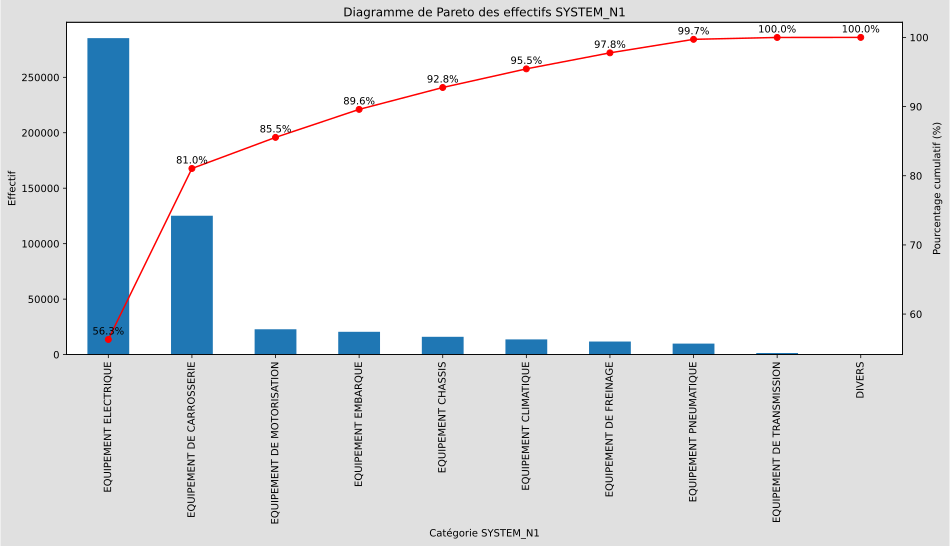

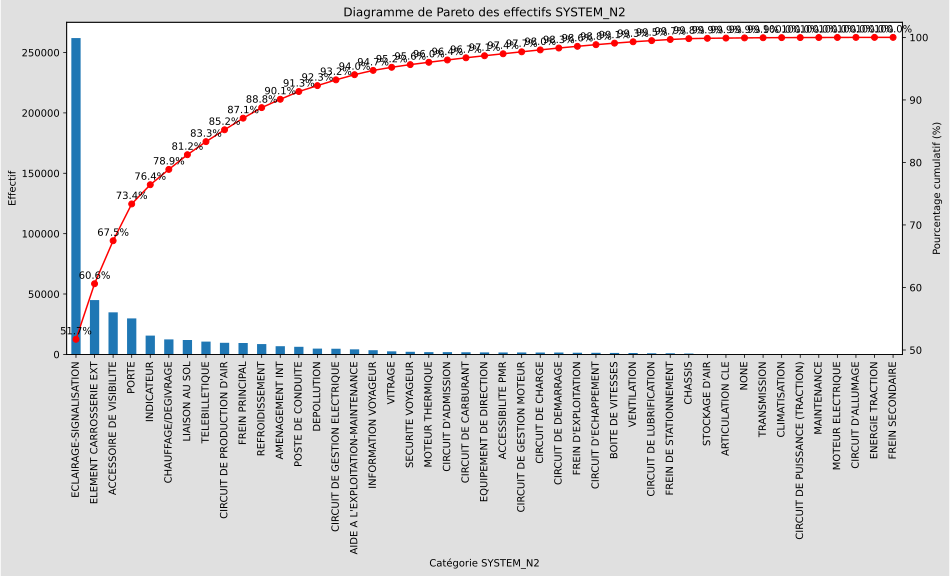

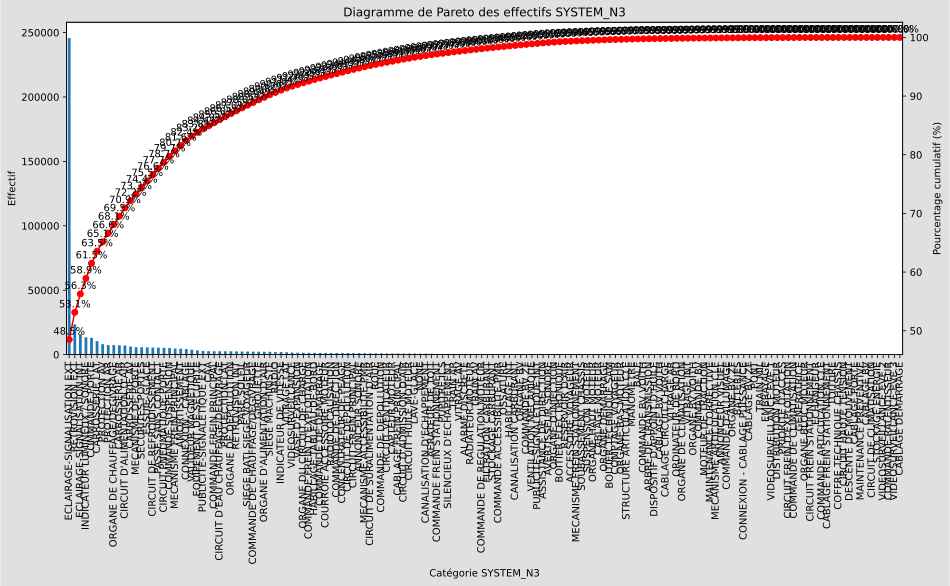

In [15]:
cols = ['SYSTEM_N1', 'SYSTEM_N2', 'SYSTEM_N3']
effectifs = {k : merged_df[k].value_counts() for k in cols}
cumulative_percentages = {k : effectifs[k].cumsum() / effectifs[k].sum() * 100 for k in cols}

for k in cols :
    fig, ax1 = plt.subplots(figsize=(15, 6))
    effectifs[k].plot(kind='bar', ax=ax1)
    ax1.set_ylabel('Effectif')
    ax1.set_xlabel(f'Catégorie {k}')
    ax2 = ax1.twinx()
    cumulative_percentages[k].plot(kind='line', color='red', marker='o', ax=ax2)
    ax2.set_ylabel('Pourcentage cumulatif (%)')

    plt.title(f'Diagramme de Pareto des effectifs {k}')
    ax1.set_xticklabels(effectifs[k].index, rotation=90)

    # Afficher les pourcentages sur la courbe
    for i, value in enumerate(cumulative_percentages[k]) :
        ax2.annotate(f'{value:.1f}%', (i, value), textcoords="offset points", xytext=(0, 5), ha='center')

    plt.show()

Mesure des effectifs des paramètres LIGNE, MODELE, CONSTRUCTEUR, MOTEUR

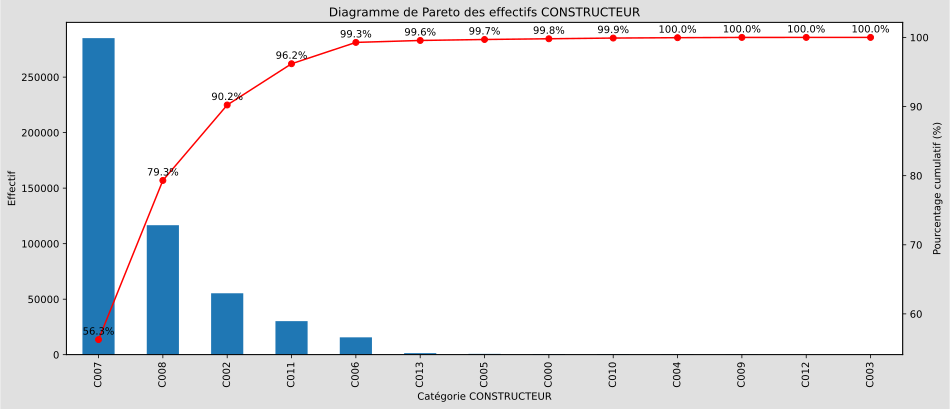

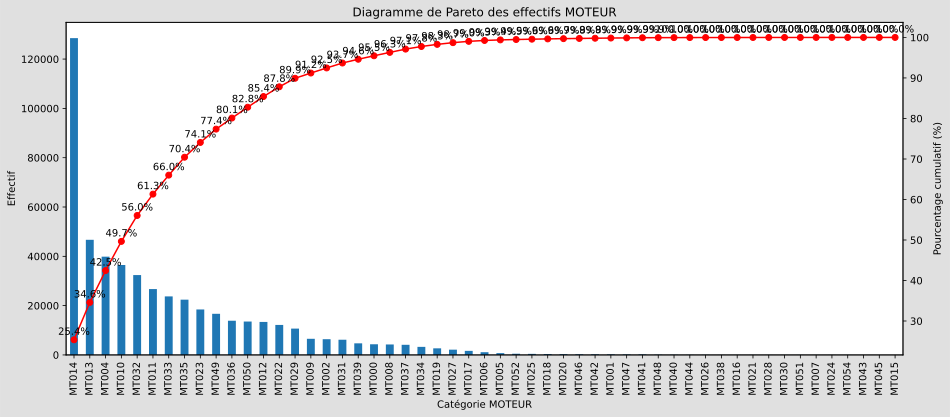

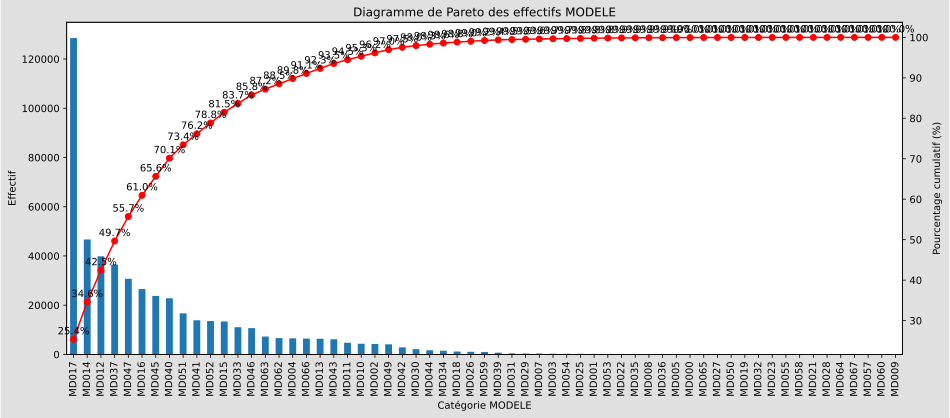

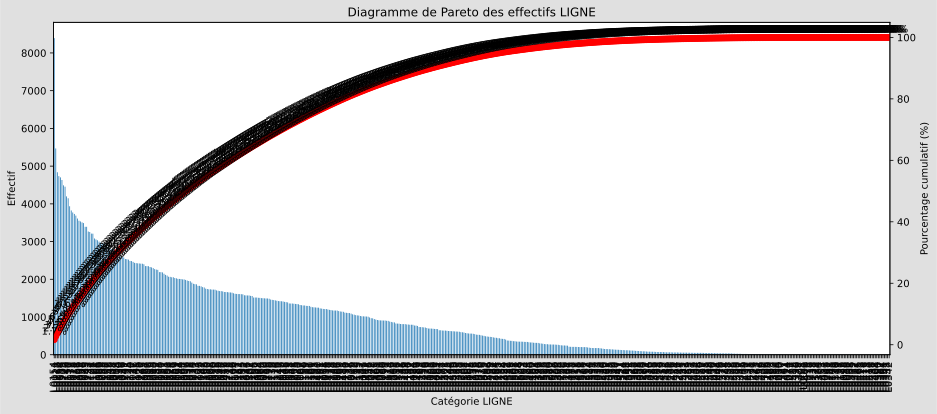

In [16]:
cols = ['CONSTRUCTEUR', 'MOTEUR', 'MODELE', 'LIGNE']
effectifs = {k : merged_df[k].value_counts() for k in cols}
cumulative_percentages = {k : effectifs[k].cumsum() / effectifs[k].sum() * 100 for k in cols}

for k in cols :
    fig, ax1 = plt.subplots(figsize=(15, 6))
    effectifs[k].plot(kind='bar', ax=ax1)
    ax1.set_ylabel('Effectif')
    ax1.set_xlabel(f'Catégorie {k}')
    ax2 = ax1.twinx()
    cumulative_percentages[k].plot(kind='line', color='red', marker='o', ax=ax2)
    ax2.set_ylabel('Pourcentage cumulatif (%)')

    plt.title(f'Diagramme de Pareto des effectifs {k}')
    ax1.set_xticklabels(effectifs[k].index, rotation=90)

    # Afficher les pourcentages sur la courbe
    for i, value in enumerate(cumulative_percentages[k]) :
        ax2.annotate(f'{value:.1f}%', (i, value), textcoords="offset points", xytext=(0, 5), ha='center')

    plt.show()

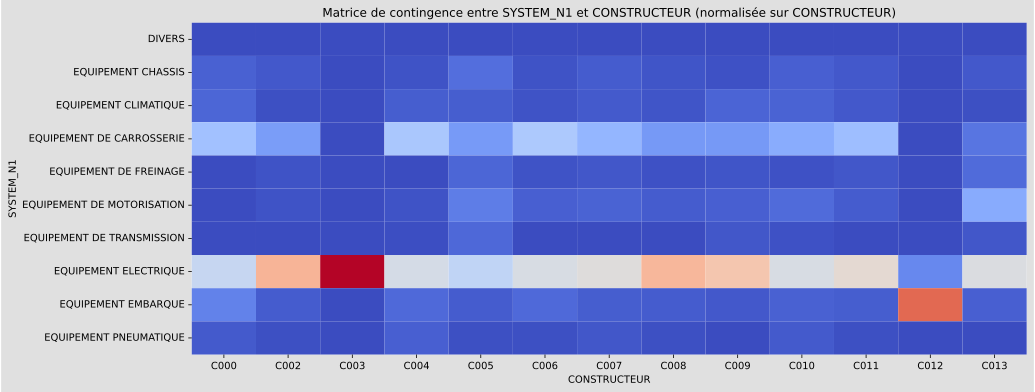

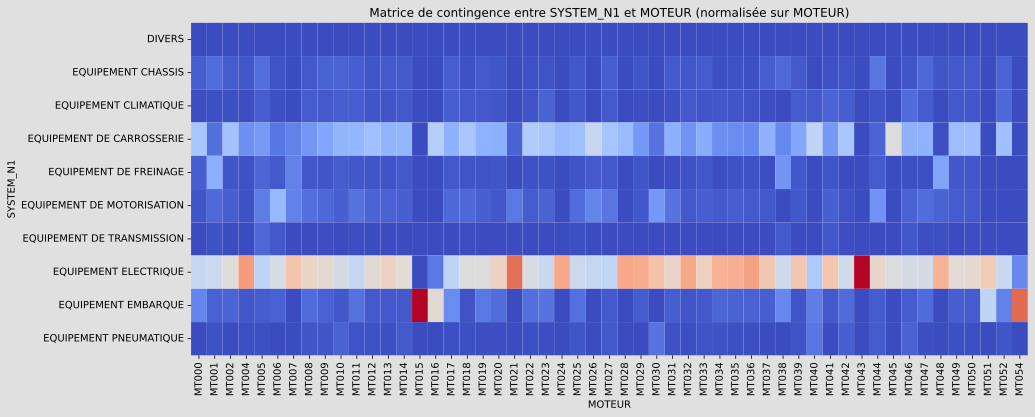

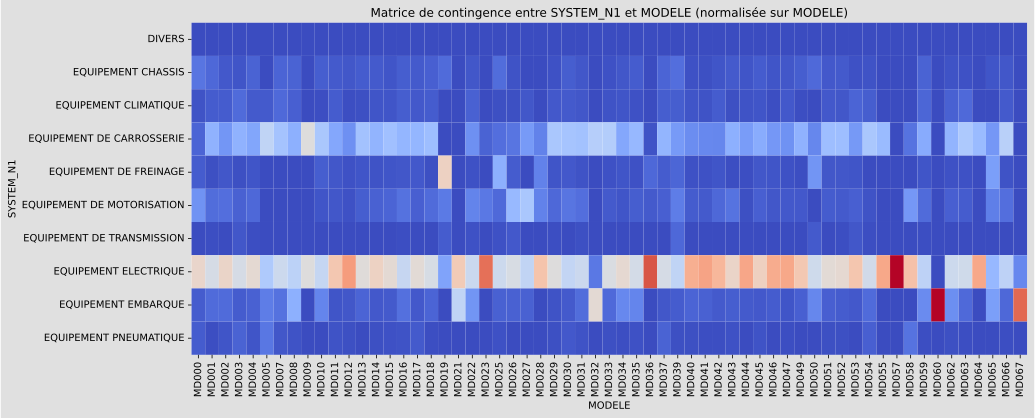

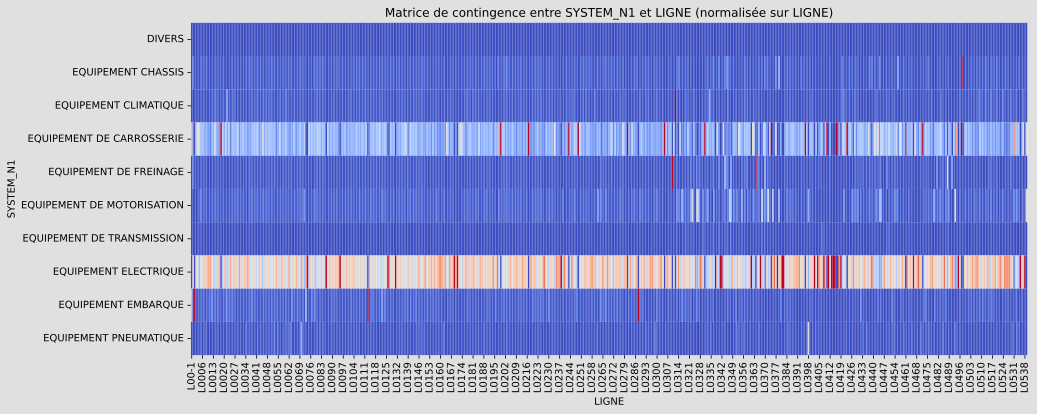

In [17]:
cols = ['CONSTRUCTEUR', 'MOTEUR', 'MODELE', 'LIGNE']
panne = 'SYSTEM_N1'

for k in cols :
    contingency_table = pd.crosstab(merged_df[panne],merged_df[k], normalize='columns')
    plt.figure(figsize=(15, 6))
    sns.heatmap(contingency_table, annot=False, cmap='coolwarm', cbar=False)
    plt.title(f'Matrice de contingence entre {panne} et {k} (normalisée sur {k})')
    plt.show()